<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span><ul class="toc-item"><li><span><a href="#Quaternion-functions:" data-toc-modified-id="Quaternion-functions:-2.1">Quaternion functions:</a></span></li><li><span><a href="#General-purpose-ops-(Utils)" data-toc-modified-id="General-purpose-ops-(Utils)-2.2">General purpose ops (Utils)</a></span></li></ul></li><li><span><a href="#Projection-module" data-toc-modified-id="Projection-module-3">Projection module</a></span><ul class="toc-item"><li><span><a href="#Camera-transformation" data-toc-modified-id="Camera-transformation-3.1">Camera transformation</a></span></li><li><span><a href="#Voxels-from-point-clouds" data-toc-modified-id="Voxels-from-point-clouds-3.2">Voxels from point clouds</a></span></li><li><span><a href="#Voxels-smoothing" data-toc-modified-id="Voxels-smoothing-3.3">Voxels smoothing</a></span></li><li><span><a href="#Projection-and-point-cloud-dropout" data-toc-modified-id="Projection-and-point-cloud-dropout-3.4">Projection and point cloud dropout</a></span></li></ul></li><li><span><a href="#Models" data-toc-modified-id="Models-4">Models</a></span><ul class="toc-item"><li><span><a href="#Common" data-toc-modified-id="Common-4.1">Common</a></span></li><li><span><a href="#Point-cloud-decoder" data-toc-modified-id="Point-cloud-decoder-4.2">Point cloud decoder</a></span></li><li><span><a href="#Pose-decoder" data-toc-modified-id="Pose-decoder-4.3">Pose decoder</a></span></li><li><span><a href="#SupervisedModel" data-toc-modified-id="SupervisedModel-4.4">SupervisedModel</a></span></li><li><span><a href="#Unsupervised-model" data-toc-modified-id="Unsupervised-model-4.5">Unsupervised model</a></span></li></ul></li><li><span><a href="#Data" data-toc-modified-id="Data-5">Data</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-6">Training</a></span><ul class="toc-item"><li><span><a href="#Overfit-one-batch" data-toc-modified-id="Overfit-one-batch-6.1">Overfit one batch</a></span></li><li><span><a href="#Training-loop" data-toc-modified-id="Training-loop-6.2">Training loop</a></span></li><li><span><a href="#Train-models" data-toc-modified-id="Train-models-6.3">Train models</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-7">Evaluation</a></span></li></ul></div>

## Imports

In [1]:
import os
import time
import shutil
import math

from pathlib import Path
from collections import defaultdict

Data loading, visualization and evaluation

In [2]:
import numpy as np
import open3d as o3
import matplotlib.pyplot as plt

from PIL import Image
from scipy.io import loadmat
from scipy.spatial.transform import Rotation

Models

In [84]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as T

from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm

## Functions

General tensor operations

### Quaternion functions:

In [6]:
def points2quat(v):
    "Convert xyz points to quaternions"
    assert len(v.shape) == 3
    assert v.size(-1) == 3
    return F.pad(v, (1, 0, 0, 0))

def quatmul(q1, q2):
    "Multiply quaternions"
    w1, x1, y1, z1 = torch.unbind(q1, dim=-1)
    w2, x2, y2, z2 = torch.unbind(q2, dim=-1)

    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return torch.stack([w, x, y, z], dim=-1)

def quatconj(q):
    "Conjugate of quaternion"
    m = q.new(4).fill_(-1)
    m[0] = 1.0
    return q * m 

def quatrot(v, q, inverse=False):
    "Rotate points v [b, n, 3] with quaternions q [b, 4]"
    q = F.normalize(q, dim=-1)
    q = q[:, None, :]
    q_ = quatconj(q)
    v = points2quat(v)

    if inverse:
        wxyz = quatmul(quatmul(q_, v), q)
    else:
        wxyz = quatmul(quatmul(q, v), q_)
        
    if len(wxyz.shape) == 2:
        wxyz = wxyz.unsqueeze(0)

    return wxyz[:, :, 1:4]


def quat_from_campos(pos):
    "Convert blender camera format `pos` to torch tensor quaternion [w, x, y, z]"
    cx, cy, cz = pos[0]
    camDist = math.sqrt(cx * cx + cy * cy + cz * cz)
    cx = cx / camDist
    cy = cy / camDist
    cz = cz / camDist
    t = math.sqrt(cx * cx + cy * cy)
    tx = cx / t
    ty = cy / t
    yaw = math.acos(tx)
    if ty > 0:
        yaw = 2 * math.pi - yaw

    roll = 0
    pitch = math.asin(cz)
    yaw = yaw + math.pi

    quat = Rotation.from_euler("yzx", [yaw, pitch, roll]).as_quat()
    quat = np.r_[quat[-1], quat[:-1]]

    return torch.tensor(quat.astype(np.float32))

### General purpose ops (Utils)

In [7]:
def repeat_tensor_batch(tensor, times):
    "Repeat tensor `times` times for each element in batch"
    if tensor is None: return

    data_shape = tensor.shape[1:]
    repeats = [1, times] + [1] * len(data_shape)

    expanded = tensor.unsqueeze(1).repeat(*repeats)
    return expanded.view(-1, *data_shape)

In [163]:
def generate_projections_img(model, imgs, poses, masks):
    "Generate grid with model projections, gt projections and input images"
    device = next(model.parameters()).device
    proj, *_ = model(imgs[0].unsqueeze(0).to(device), poses.to(device))
    proj = proj.detach().cpu()

    grid = torch.cat([
        F.interpolate(imgs, scale_factor=1/2, mode='bilinear', align_corners=True),
        F.interpolate(masks.unsqueeze(1), scale_factor=1/2, mode='bilinear', align_corners=True).repeat(1, 3, 1, 1),
        proj.unsqueeze(1).repeat(1, 3, 1, 1),
    ])
    
    grid = make_grid(grid, nrow=imgs.size(0))
    return F.interpolate(grid.unsqueeze(0), scale_factor=2)

## Projection module
Most of the module is implemented as functions, as almost all operations don't have learnable parameters. I tried to set default hyperparameter values as mentioned in paper

### Camera transformation 
camera had same $z$ coordinate with different angles and $x$, $y$ positions

In [9]:
def pc_camera_transform(pc, rotation, focal_lenght=1.875, camera_distance=2.0):
    "Transform pontcloud `pc` to camera coordinates with `rotation`"
    
    pc = quatrot(pc, rotation)
    zs, ys, xs = torch.unbind(pc, dim=2)
    
    xs = xs * focal_lenght / (zs + camera_distance)
    ys = ys * focal_lenght / (zs + camera_distance)

    return torch.stack([zs, ys, xs], dim=2)

### Voxels from point clouds

Fit point cloud to 3d grid with trilinear interpolation

In [10]:
def pc_voxels(pc, size=64, eps=1e-6):
    "Create voxels of `[size]*3` from pointcloud `pc`"
    # save for later
    vox_size = pc.new(3).fill_(size)
    bs = pc.size(0)
    n = pc.size(1)
    
    # check borders
    valid = ((pc < 0.5 - eps) & (pc > -0.5 + eps)).all(dim=-1).view(-1)
    grid = (pc + 0.5) * (vox_size - 1)
    grid_floor = grid.floor()

    grid_idxs = grid_floor.long()
    batch_idxs = torch.arange(bs)[:, None, None].repeat(1, n, 1).to(pc.device)
    # idxs of form [batch, z, y, x] where z, y, x discretized indecies in voxel
    idxs = torch.cat([batch_idxs, grid_idxs], dim=-1).view(-1, 4)
    idxs = idxs[valid]

    # trilinear interpolation
    r = grid - grid_floor
    rr = [1. - r, r]
    voxels = []
    voxels_t = pc.new(bs, size, size, size).fill_(0)

    def trilinear_interp(pos):
        update = rr[pos[0]][..., 0] * rr[pos[1]][..., 1] * rr[pos[2]][..., 2]
        update = update.view(-1)[valid]
        
        shift_idxs = torch.LongTensor([[0] + pos]).to(pc.device)
        shift_idxs = shift_idxs.repeat(idxs.size(0), 1)
        update_idxs = idxs + shift_idxs
        valid_shift = update_idxs < size
        voxels_t.index_put_(torch.unbind(update_idxs, dim=1), update, accumulate=True)

        return voxels_t
        
    
    for k in range(2):
        for j in range(2):
            for i in range(2):
                voxels.append(trilinear_interp([k, j, i]))
    
    return torch.stack(voxels).sum(dim=0).clamp(0, 1)

### Voxels smoothing

Fast gaussian smoothing of a voxel. There was an issue with speed of pytorch conv3d backward pass in this operation. I solved it by reordering batch and channels dimensions and using groups. It turned out to be 10x faster. Batch parallelization of `conv3d` vs channel parallelization (second is faster in this case with $1$ channel in voxel and $\approx 40$ voxels per batch)

In [11]:
def smoothing_kernel(sigma, kernel_size=21):
    "Generate 3 separate gaussian kernels with `sigma` stddev"
    x = torch.arange(-kernel_size//2 + 1., kernel_size//2 + 1., device=sigma.device)
    kernel_1d = torch.exp(-x**2 / (2. * sigma**2))
    kernel_1d = kernel_1d / kernel_1d.sum()

    k1 = kernel_1d.view(1, 1, 1, 1, -1)
    k2 = kernel_1d.view(1, 1, 1, -1, 1)
    k3 = kernel_1d.view(1, 1, -1, 1, 1)
    return [k1, k2, k3]

def voxels_smooth(voxels, kernels, scale=None):
    "Apply gaussian blur to voxels with separable `kernels` then `scale`"
    assert isinstance(kernels, list)

    # add fake channel for convs
    bs = voxels.size(0)
    voxels = voxels.unsqueeze(0)

    for k in kernels:
        # add padding for kernel dimension
        padding = [0] * 3
        padding[np.argmax(k.shape) - 2] = max(k.shape) // 2

        voxels = F.conv3d(voxels, k.repeat(bs, 1, 1, 1, 1), stride=1, padding=padding, groups=bs)

    voxels = voxels.squeeze(0)

    if scale is not None:
        voxels = voxels * scale.view(-1, 1, 1, 1)
        voxels = voxels.clamp(0, 1)

    return voxels

### Projection and point cloud dropout

In [12]:
def drc_prob(voxels, clip_val=1e-5):
    "Compute termination probabilities from part 4 https://arxiv.org/pdf/1810.09381.pdf"
    inp = voxels.permute(1, 0, 2, 3)
    inp = inp.clamp(clip_val, 1.0 - clip_val)
    zero = voxels.new(1, inp.size(1), inp.size(2), inp.size(3)).fill_(clip_val)

    y = torch.log(inp)
    x = torch.log(1 - inp)

    r = torch.cumsum(x, dim=0)
    p1 = torch.cat([zero, r], dim=0)
    p2 = torch.cat([y, zero], dim=0)

    p = p1 + p2
    return torch.exp(p).permute(1, 0, 2, 3)

Class, which handles projection from point cloud(s) to images of this ponit cloud(s) at different rotatoins. The result is $N_{\mathrm{batch}} \cdot N_{\mathrm{views}} \times N_{\mathrm{img}} \times N_{\mathrm{img}}$, so each point cloud is rotated multiple times (read: repeated for each view in batch).

In [13]:
class Projection(nn.Module):
    "Diffefentiable point cloud projection module"
    def __init__(self, vox_size=64, smooth_ks=21, smooth_sigma=3.0):
        super().__init__()
        self.vox_size = vox_size
        self.ks = smooth_ks
        self.register_buffer('sigma', torch.tensor(smooth_sigma))

    def forward(self, pc, rotation, scale=None):
        "Project points `pc` to camera givne by `transform`"
        pc = pc_camera_transform(pc, rotation)
        voxels = pc_voxels(pc, self.vox_size)
        smooth = voxels_smooth(voxels, kernels=smoothing_kernel(self.sigma, self.ks), scale=scale)

        prob = drc_prob(smooth)
        proj = prob[:, :-1].sum(1).flip(1)
        return proj

Point cloud dropout keeps only `keep_prob` points in each point cloud of a batch (different points for each example in one batch)

In [14]:
class PointCloudDropout(nn.Module):
    "Drop random portions of pointclouds `pc`"
    def __init__(self, keep_prob=0.07):
        super().__init__()
        self.keep_prob = keep_prob
        
    def forward(self, pc):
        bs, n_points = pc.size(0), pc.size(1)
        n_keep = math.ceil(n_points * self.keep_prob)

        batch_idxs = repeat_tensor_batch(torch.arange(bs), n_keep)
        point_idxs = torch.cat([torch.randperm(n_points)[:n_keep] for i in range(bs)])

        return pc[batch_idxs, point_idxs].view(bs, n_keep, -1)

## Models

Both camera supervised and unsupervised models are implemented below

### Common 

blocks used in modules

In [15]:
def conv_block(in_ch, out_ch, ks=3, stride=1, padding=1, bn=True, act=True):
    "Basic convolutional block with relu and batchnorm"
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, ks, stride, padding, bias=not bn),
        nn.ReLU(True) if act else nn.Identity(),
        nn.BatchNorm2d(out_ch) if bn else nn.Identity(),
    )

def pose_predictor(n_ft):
    "Pose predictor with 2 hidden layers"
    return nn.Sequential(
        nn.Linear(n_ft, n_ft),
        nn.ReLU(True),
        nn.Linear(n_ft, n_ft),
        nn.ReLU(True),
        nn.Linear(n_ft, 4),
    )

def weight_init(m):
    "Kaiming normal init for relu with slope 0 for linear and conv layers"
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight.data, a=0)

Encoder is almost as in original paper, but with batch normalization and ReLU activations with kaiming normal initialization.

In [16]:
class Encoder(nn.Module):
    "Encodes input images"
    def __init__(self, img_size, hidden_dim):
        super().__init__()
        self.convs = nn.Sequential(                       
            conv_block(3, 16,  ks=5, stride=2, padding=2),
            conv_block(16, 16, ks=3, stride=2),            
            conv_block(16, 16, ks=3, stride=1),          
            conv_block(16, 16, ks=3, stride=2),           
            conv_block(16, 16, ks=3, stride=1),
            conv_block(16, 16, ks=3, stride=2),           
            conv_block(16, 16, ks=3, stride=1),
            conv_block(16, 16, ks=3, stride=2),          
            conv_block(16, 16, ks=3, stride=1),
        )
        
        self.features = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 16, 1024, bias=False),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 1024),
        )

    def forward(self, img):
        conv_features = self.convs(img)
        features = self.features(conv_features)
        
        return features

### Point cloud decoder 

used to generate point clouds from hidden vector of encoder

In [17]:
class PointCloudDecoder(nn.Module):
    def __init__(self, num_points, hidden_dim=1024, predict_scale=True):
        super().__init__()
        self.num_points = num_points
        self.predict_scale = predict_scale
        self.pc_decoder = nn.Linear(hidden_dim, num_points * 3)
        self.scale_decoder = nn.Linear(hidden_dim, 1)
        
    def forward(self, z):
        "Transform hidden vector to pointcloud"
        # predict pointcloud
        pc = self.pc_decoder(z)
        pc = pc.view(-1, self.num_points, 3)
        pc = torch.tanh(pc) / 2.0

        scale = None
        if self.predict_scale:
            scale = self.scale_decoder(z)
            scale = torch.sigmoid(scale)

        return pc, scale

### Pose decoder

In pose branch `hidden_dim` is slightly bigger than in paper. Pose decoder in `eval` mode returns one pose for each example in batch. In `train` mode it returns `num_candidates` poses for each example (one additional pose is student prediction). In this case poses are repeated in batch dimension like `num_candidates` poses for first example, ..., `num_candidates` poses for nth example. In this setting we can use `repeat_tensor_batch` to replicate point clouds for each view and get projections.

In [18]:
class PoseDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_candidates=4):
        "Predict `num_candidates` pose candidates for each example in batch"
        super().__init__()

        # Shared part
        self.ensemble = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
        )

        self.predictors = nn.ModuleList([pose_predictor(hidden_dim) for i in range(num_candidates)])

        self.student = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            pose_predictor(hidden_dim)
        )

    def forward(self, z):
        "Transform hidden vector to rotation quaternions"
        student_quat = self.student(z)

        if not self.training:
            return student_quat
        
        ensemble = self.ensemble(z)
        all_quats = [p(ensemble) for p in self.predictors]
        ensemble_quat = torch.cat(all_quats, dim=-1).view(-1, 4)

        return torch.cat([ensemble_quat, student_quat], dim=0)

### SupervisedModel

`SupervisedModel` uses camera supervision and only predicts and projects point clouds to different cameras

In [158]:
a, *_ = [1]

In [159]:
_

[]

In [147]:
class SupervisedModel(nn.Module):
    "Basic model"
    def __init__(
        self, img_size=128, hidden_dim=1024, num_points=8000, 
        vox_size=64, smooth_sigma=3.0, predict_scale=True, keep_prob=0.1,
    ):
        super().__init__()
        self.encoder = Encoder(img_size, hidden_dim)
        self.decoder = PointCloudDecoder(num_points, hidden_dim, predict_scale)
        self.pc_dropout = PointCloudDropout(keep_prob)
        self.pc_projection = Projection(vox_size, smooth_sigma=smooth_sigma)

        self.encoder.apply(weight_init)
        self.decoder.apply(weight_init)

    def forward(self, imgs, poses):
        "Generate new view of `imgs` from `cameras` using differentiable projection"
        bs = imgs.size(0)
        num_views = poses.size(0) // bs

        z = self.encoder(imgs)
        pc, scale = self.decoder(z)

        pc    = repeat_tensor_batch(self.pc_dropout(pc), num_views)
        scale = repeat_tensor_batch(scale, num_views)
        proj  = self.pc_projection(pc, poses, scale)

        return proj
    

class SupervisedLoss(nn.Module):
    "Mse loss / 2"
    def forward(self, proj, masks, **kwargs):
        proj = F.interpolate(proj.unsqueeze(0), scale_factor=2, mode='bilinear', align_corners=True).squeeze()
        return dict(full_loss=F.mse_loss(proj, masks, reduction='sum') / (2 * proj.size(0)))

### Unsupervised model


In [154]:
class UnsupervisedModel(nn.Module):
    "Unsupervised model with ensemble of pose predictors"
    def __init__(self, img_size=128, vox_size=64, 
                 z_dim=1024, pose_dim=128, 
                 num_points=8000, num_candidates=4, num_views=5):
        super().__init__()
        self.num_views = num_views
        self.num_candidates = num_candidates

        self.encoder = Encoder(img_size, z_dim)
        self.pc_decoder = PointCloudDecoder(num_points, hidden_dim=z_dim)
        self.pc_dropout = PointCloudDropout()
        self.pc_projection = Projection(vox_size)
        self.pose_decoder = PoseDecoder(input_dim=z_dim, hidden_dim=pose_dim, num_candidates=num_candidates)

    def forward(self, imgs, poses):
        z, z_p = self.encoder(imgs), self.encoder(poses)
        pc, scale = self.pc_decoder(z)
        poses = self.pose_decoder(z_p)

        # No ensemble on inference
        if not self.training:
            bs = imgs.size(0)
            pc    = repeat_tensor_batch(self.pc_dropout(pc), self.num_views)
            scale = repeat_tensor_batch(scale, self.num_views)
            proj  = self.pc_projection(pc, poses, scale)
            return proj, poses

        bs = imgs.size(0) * self.num_views
        ensemble_poses, student_poses = poses[:-bs], poses[-bs:]

        pc    = repeat_tensor_batch(self.pc_dropout(pc), self.num_candidates * self.num_views)
        scale = repeat_tensor_batch(scale, self.num_candidates * self.num_views)
        proj = self.pc_projection(pc, ensemble_poses, scale)

        return proj, ensemble_poses, student_poses

In [179]:
class UnsupervisedLoss(nn.Module):
    "Loss combines projection losses for ensemble and student loss"
    def __init__(self, num_candidates=4, student_weight=20.0):
        super().__init__()
        self.student_weight = student_weight
        self.num_candidates = num_candidates
    
    def forward(self, pred, masks, training):
        proj, *poses = pred
        proj = F.interpolate(proj.unsqueeze(0), scale_factor=2, mode='bilinear', align_corners=True).squeeze()

        if not training:
            return dict(projection_loss=F.mse_loss(proj, masks, reduction='sum') / proj.size(0))
        
        ensemble_poses, student_poses = poses
        masks = repeat_tensor_batch(masks, self.num_candidates)

        projection_loss = F.mse_loss(proj, masks, reduction='none')
        projection_loss = projection_loss.sum((1,2)).view(-1, self.num_candidates)
        min_idxs = projection_loss.argmin(dim=-1)
        batch_idxs = torch.arange(min_idxs.size(0), device=min_idxs.device)
        
        # Student loss
        min_projection_loss = projection_loss[batch_idxs, min_idxs].sum() / min_idxs.size(0)
        ensemble_poses = ensemble_poses.view(-1, self.num_candidates, 4)
        best_poses = ensemble_poses[batch_idxs, min_idxs, :].detach()
        
        poses_diff = F.normalize(quatmul(best_poses, quatconj(student_poses)), dim=-1)
        angle_diff = poses_diff[:, 0]
        student_loss = (1 - angle_diff**2).sum() / min_idxs.size(0)
        
        return dict(
            projection_loss=min_projection_loss,
            student_loss=student_loss,
            full_loss=min_projection_loss + self.student_weight * student_loss,
        )
        

## Data

We use splits and renders from authors of the paper (but we train on train + test and validate on val). There is an option in dataset to load camera positions instead of other views. We always load all 5 renders (for simplicity)

In [ ]:
!wget --quiest --show-progress "https://datasets.d2.mpi-inf.mpg.de/unsupervised-shape-pose/{DataBunch._ids["chairs"]}-renders.tar.gz"
!wget --quiest --show-progress "https://datasets.d2.mpi-inf.mpg.de/unsupervised-shape-pose/{DataBunch._ids["planes"]}-renders.tar.gz"
!wget --quiest --show-progress "https://datasets.d2.mpi-inf.mpg.de/unsupervised-shape-pose/{DataBunch._ids["cars"]}-renders.tar.gz"

In [34]:
!tar -xzf "{DataBunch._ids["chairs"]}-renders.tar.gz"
!tar -xzf "{DataBunch._ids["planes"]}-renders.tar.gz"
!tar -xzf "{DataBunch._ids["cars"]}-renders.tar.gz"

In [37]:
!mv "{DataBunch._ids["chairs"]}" data
!mv "{DataBunch._ids["planes"]}" data
!mv "{DataBunch._ids["cars"]}" data

!rm "{DataBunch._ids["chairs"]}-renders.tar.gz"
!rm "{DataBunch._ids["planes"]}-renders.tar.gz"
!rm "{DataBunch._ids["cars"]}-renders.tar.gz"

Pytorch dataset

In [23]:
def get_models(path=".", shapenet_id="03001627", split="train"):
    "Read model paths from split file"
    path = Path(path)

    assert split in ("train", "valid")
    split = path/f"{shapenet_id}.{split}"
    data = path/shapenet_id

    with open(split) as models:
        return [data/m.strip() for m in models]


class Shapenet(Dataset):
    "Dataset with renders and views for shapenet category"
    def __init__(self, models, camera=True):
        self.models = models
        self.camera = camera

    def __getitem__(self, idx):
        model = self.models[idx]
        images = []
        masks = []
        cameras = []

        for name in sorted(os.listdir(model)):
            if name.startswith("render"):
                o = np.array(Image.open(model/name))
                mask = o[..., -1].astype(np.float32) / 255.
                img = o[..., :-1].astype(np.float32) / 255.
                
                images.append(torch.tensor(img).permute(2, 0, 1))
                masks.append(torch.tensor(mask))
                
            if name.startswith("camera"):
                camera = loadmat(model/name)
                cameras.append(quat_from_campos(camera["pos"]))
        
        images = torch.stack(images)
        masks = torch.stack(masks)
        if self.camera: poses = torch.stack(cameras)
        else:           poses = images

        return images, poses, masks
    
    def __len__(self):
        return len(self.models)

Collate function handles sampling one image for point cloud generation. `views` might be cameras or images (depends on dataset configuration, but either way it is some information about other views)

In [24]:
def multi_view_collate(batch):
    "Prepare batch with 1 image and n_poses masks and poses per item"
    bs = len(batch)
    n_poses = batch[0][0].size(0)

    idxs = torch.randint(0, n_poses, size=(bs,))
    imgs, poses, masks = zip(*[(img[i], view, mask) for (img, view, mask), i in zip(batch, idxs)])

    imgs = torch.stack(imgs)
    poses = torch.cat(poses, dim=0)
    masks = torch.cat(masks, dim=0)
    
    return imgs, poses, masks

Datasets and dataloaders all in one class:

In [25]:
class DataBunch():
    _ids = {
        "chairs": "03001627",
        "planes": "02691156",
        "cars": "02958343",
    }

    def __init__(self, path, category="chairs", batch_size=10, camera=True):
        train = get_models(path, self._ids[category], "train")
        valid = get_models(path, self._ids[category], "valid")
        self.train_ds, self.valid_ds = Shapenet(train, camera), Shapenet(valid, camera)
        self.train_dl = DataLoader(
            self.train_ds, batch_size, 
            shuffle=True, collate_fn=multi_view_collate, drop_last=True, 
            pin_memory=torch.cuda.is_available(), num_workers=4,
        )
        self.valid_dl = DataLoader(
            self.valid_ds, batch_size * 2, 
            shuffle=False, collate_fn=multi_view_collate, 
            pin_memory=torch.cuda.is_available(),
        )

## Training

Lets try to overfit one example and see what happens

### Overfit one batch

In [45]:
model = SimpleModel(img_size=128, smooth_sigma=3.0)

In [196]:
torch.random.manual_seed(10)
model = SimpleModel(img_size=128, smooth_sigma=3.0).cuda()

opt = torch.optim.Adam(model.parameters(), lr=1e-4)
torch.random.manual_seed(10)
imgs, cams, masks = next(iter(train_dl))

imgs = imgs.cuda()
cams = cams.cuda()
masks = masks.cuda()

In [197]:
pbar = tqdm_notebook(range(1000))

for i in pbar:
    t1 = time.perf_counter()
    proj = model(imgs, cams)
    targ = F.interpolate(masks.unsqueeze(0), scale_factor=1/2, mode='bilinear', align_corners=False).squeeze()

    loss = F.mse_loss(proj, targ, reduction='sum') / targ.size(0)
    loss.backward()
    opt.step()
    opt.zero_grad()
    dt = time.perf_counter() - t1

    pbar.set_postfix(time=dt, loss=loss.item())


KeyboardInterrupt: 

### Training loop

In [80]:
def loopy(dl):
    "Loop through dataloader indefinitley"
    while True:
        for o in dl: yield o

In [79]:
def adjust_params(model, step, keep_prob=(0.07, 1.0), sigma=(3.0, 0.2)):
    "Schedule model parameters linearly (dropout keep_prob and smoothing sigma)"
    assert 0 <= step <= 1

    new_keep_prob = keep_prob[0] * (1 - step) + keep_prob[1] * step
    new_sigma = sigma[0] * (1 - step) + sigma[1] * step
    
    model.pc_dropout.keep_prob = new_keep_prob
    model.pc_projection.sigma  = torch.empty_like(model.pc_projection.sigma).fill_(new_sigma)

Class for training models and capturing progress

In [180]:
class Learner:
    "Class for training a model"
    def __init__(self, path, data, model, loss, lr=1e-3, wd=0.001, seed=100):
        torch.random.manual_seed(seed)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.path = Path(path)
        if self.path.exists():
            shutil.rmtree(self.path)
        (self.path/"models").mkdir(exist_ok=True, parents=True)

        self.train_writer = SummaryWriter(log_dir=self.path/"logs"/"train")
        self.valid_writer = SummaryWriter(log_dir=self.path/"logs"/"valid")
        self.valid_losses = []

        self.data = data
        self.model = model.to(self.device)
        self.loss = loss
        self.opt = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=wd)

    def fit(self, steps=300_000, eval_every=10_000, vis_every=1000):
        "Train model for `steps` steps"
        pbar = tqdm(range(1, steps + 1), desc="Step")
        train_dl = loopy(self.data.train_dl)
        
        for step in pbar:
            self.model.train()
            adjust_params(model, step / steps)
            self.step = step
            self.imgs, self.poses, self.masks = next(train_dl)
            self.one_batch()

            if step % eval_every == 0:
                self.model.eval()
                with torch.no_grad():
                    i=0
                    for self.imgs, self.poses, self.masks in tqdm(self.data.valid_dl, leave=False):
                        self.one_batch()
                        i+=1
                        if i == 3:
                            break
                    self.write_valid_losses()

                torch.save(
                    dict(model=self.model.state_dict(), opt=self.opt.state_dict(), step=self.step), 
                    self.path/"models"/f"model_{self.step}.pth"
                )

            if step % vis_every == 0:
                self.model.eval()
                imgs, poses, masks = self.data.valid_ds[10]
                renders = generate_projections_img(self.model, imgs, poses, masks)
                self.train_writer.add_images("renders", renders, self.step)


    def one_batch(self):
        "Run one batch of a model"
        device = self.device
        imgs, poses, masks = self.imgs.to(device),self.poses.to(device),self.masks.to(device)

        proj = self.model(imgs, poses)
        loss = self.loss(proj, masks, training=self.model.training)
        if not self.model.training:
            self.valid_losses.append({key: l.item() for key, l in loss.items()})
            return

        loss['full_loss'].backward()
        self.opt.step()
        self.opt.zero_grad()
        
        for key, l in loss.items():
            self.train_writer.add_scalar(key, l.item(), self.step)

    def write_valid_losses(self):
        "Calculate means for all validation losses and write to tensorboard"
        means = defaultdict(int)
        for loss in self.valid_losses:
            for key, val in loss.items():
                means[key] += val

        for key in means.keys():
            self.valid_writer.add_scalar(key, means[key] / len(self.valid_losses), self.step)
            print(f"{key}={means[key]/len(self.valid_losses):.3f}", end=" ")
        print()
        self.valid_losses = []

### Train models

In [181]:
data = DataBunch(path="data", batch_size=2, camera=False)
learner = Learner("./test_flight", data, UnsupervisedModel(), UnsupervisedLoss())

In [182]:
learner.fit(steps=20, eval_every=2, vis_every=1)

projection_loss=3159.980 


KeyboardInterrupt: 

## Evaluation

In [77]:
torch.random.manual_seed(10)
model = SimpleModel(img_size=128, smooth_sigma=3.0).cuda()

In [78]:
checkpoint = torch.load(open("../camera_supervision/model_66000.pth", 'rb'))

In [79]:
model.load_state_dict(checkpoint['model']);

In [80]:
imgs, cams, masks = next(iter(train_dl))

In [154]:
imgs = imgs.cuda()
cams = cams.cuda()
masks = masks.cuda()

In [178]:
pc, scale = model.decoder(model.encoder.forward(imgs))

In [179]:
voxels = pc_voxels(pc)

In [180]:
kernels = smoothing_kernel(pc.new([1.0]), 21)

In [183]:
smooth_old = voxels_smooth_old(voxels, kernels).squeeze()

torch.Size([8, 1, 64, 64, 64])


In [184]:
smooth = voxels_smooth(voxels, kernels).squeeze()

torch.Size([8, 64, 64, 64])


In [186]:
torch.allclose(smooth, smooth_old)

True

In [161]:
%%time
voxels.sum().backward()

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 11.3 ms


In [136]:
drc_prob(voxels.squeeze(0))[:, ]

torch.Size([1, 65, 64, 64])

In [109]:
pc_np = pc.squeeze().detach().cpu().numpy()
pcd = o3.geometry.PointCloud()
pcd.points = o3.utility.Vector3dVector(pc_np)

In [113]:
vis = o3.JVisualizer()
vis.add_geometry(pcd)
vis.show()

Transform 0.001497567000114941 Voxels 0.008974589000899869 Smoothing 0.000893971000550664 Probability 0.0003270800007157959 Projection 0.00021775100049126195
Projection 0.01271116299994901


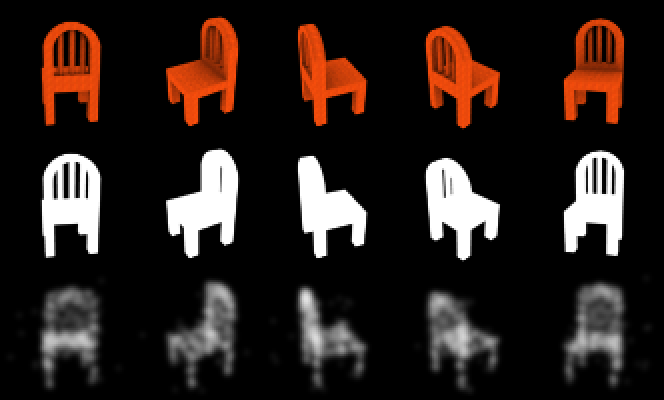

In [135]:
T.to_pil_image(generate_projections_img(model, img.cuda(), cam.cuda(), mask))